In [1]:
from __future__ import print_function, division
from nilmtk import DataSet, HDFDataStore
from os.path import join
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
from nilmtk.metrics import f1_score # metrics is actually different; need to look at this
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.disaggregate import fhmm_exact # OK, only different in what is printed to screen (and this is diagonal covariance matrix)


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
building_number = 1
ds = DataSet("/data/REDD/redd.h5")


In [3]:
train = DataSet("/data/REDD/redd.h5")
test = DataSet("/data/REDD/redd.h5")

In [4]:
elec = train.buildings[building_number].elec

In [6]:
mains = elec.mains()
df_all = mains.power_series_all_data() #df_all has a bunch of NaNs
df_all_noNan = df_all.dropna()
a = df_all_noNan.keys()
middleTime = a[int(math.floor(a.size/2))]
middleTimeStr = "%d-%02d-%02d %02d:%02d:%02d" % (middleTime.year, middleTime.month, middleTime.day, middleTime.hour, middleTime.minute, middleTime.second)

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [7]:
middleTimeStr

'2011-04-27 19:08:15'

In [8]:
train.set_window(end=middleTimeStr)
test.set_window(start=middleTimeStr)

train_elec = train.buildings[building_number].elec
test_elec = test.buildings[building_number].elec

top_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [9]:
fhmm = fhmm_exact.FHMM() #mk change this later  to default
fhmm.train(top_train_elec, sample_period=60, resample=True)
output = HDFDataStore("/data/REDD/449.h5", 'w')
fhmm.disaggregate(test_elec.mains(), output, sample_period=60, resample=True)
output.close()

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [10]:
%matplotlib inline

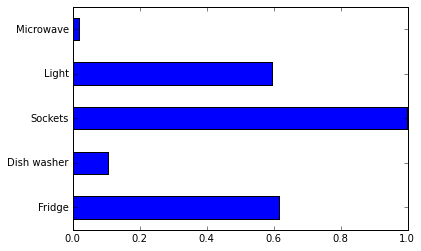

In [11]:
disag = DataSet("/data/REDD/449.h5") #load FHMM prediction
disag_elec = disag.buildings[building_number].elec

f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh')

In [12]:
rms = rms_error_power(disag_elec, elec)

In [13]:
rms

5      0.50
6     51.00
8     39.75
9     80.00
11    50.00
dtype: float64

In [14]:
mne = mean_normalized_error_power(disag_elec, elec)

In [15]:
mne

5      0.076923
6           inf
8      0.654321
9     80.000000
11    12.500000
dtype: float64